In [2]:
from potential_initialization import *
from shuttling import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
pbi, ppi = dict(), dict()

In [4]:
shuttle_range = [[-1, 1], [-0.1, 0.1], [0.05, 0.1]]
junction = trap_model("junction", shuttle_range, pbi, ppi)

100%|██████████| 400/400 [00:00<00:00, 418.31it/s]


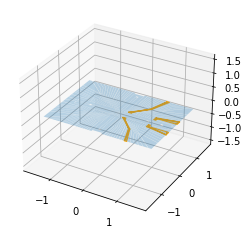

In [4]:
junction.plot(electrodode=['R-0', 'R-11'])

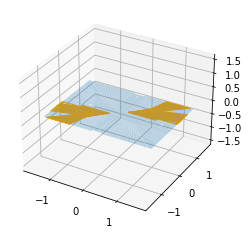

In [5]:
junction.plot(sector=[1, 5])

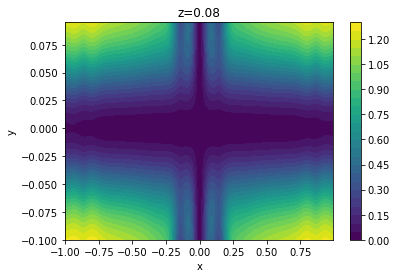

In [19]:
junction.plot_slice(voltage=np.zeros(94), z=0.08)

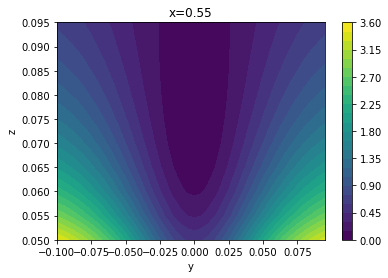

In [20]:
junction.plot_slice(voltage=np.zeros(94), x=0.55)

In [23]:
indices = junction.get_indices(use_sectors=[1, 2, 3, 4, 5, 6, 7, 8])
voltage = np.zeros(94)
voltage[indices] = 1

In [44]:
points = junction.rf_null_point(np.linspace(0.4, 0.7, 50))
voltage = np.zeros(94)
# voltage[0] = 0
# voltage[1] = 1
indices = junction.get_indices(use_sectors=[1, 8])
indices = junction.get_indices(use_sectors=[1, 2, 3, 4, 5, 6, 7, 8])
voltage[indices] = 1
for point in points:
    a = (junction.jac(point) * voltage[:, None]).sum(axis=0)
    # a /= a[2]
    # a = junction.interp(point) * voltage[:, None]
    print(a)

[ 0.28618851 -0.00495561  2.32483371]
[ 0.27013016 -0.00511457  2.33073431]
[ 0.25417224 -0.00526717  2.33686378]
[ 0.23837222 -0.00541294  2.34321111]
[ 0.22277915 -0.00555144  2.34976314]
[ 0.20743482 -0.00568226  2.35650413]
[ 0.19237468 -0.005805    2.36341984]
[ 0.17762764 -0.00591934  2.37049605]
[ 0.16321754 -0.00602496  2.37771853]
[ 0.14916395 -0.00612156  2.38507312]
[ 0.13548288 -0.0062089   2.39254591]
[ 0.12218703 -0.00628672  2.40012325]
[ 0.10928622 -0.00635482  2.40779187]
[ 0.09678802 -0.00641301  2.41553885]
[ 0.08469808 -0.00646112  2.42335166]
[ 0.07302043 -0.00649899  2.43121815]
[ 0.06175762 -0.0065265   2.43912654]
[ 0.05091112 -0.00654355  2.44706544]
[ 0.04048144 -0.00655004  2.45502377]
[ 0.03046837 -0.00654591  2.46299083]
[ 0.02087108 -0.0065311   2.47095619]
[ 0.01168834 -0.00650558  2.47890972]
[ 0.0029186  -0.00646932  2.48684151]
[-0.00543991 -0.00642234  2.49474188]
[-0.01338912 -0.00636464  2.50260133]
[-0.02093096 -0.00629625  2.5104105 ]
[-0.02806736